#### Sources

I mainly used two sources :
- https://www.youtube.com/watch?v=WFEzkoK7tsE
- https://math.stackexchange.com/questions/4168769/how-to-deal-with-copulas

#### Modules

In [ ]:
#!pip3 install openturns

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import openturns as ot
from openturns.viewer import View

#### Fake data generation

We generate observations from a bivariate Gaussian distribution with a correlation of rho = 0.80.

In [3]:
mean = [0, 0]
rho = 0.8
cov = [[1, rho],[rho, 1]]

In [4]:
norm_1, norm_2 = np.random.multivariate_normal(mean, cov, 10000).T

We create two arrays of observations based on the uniform distributions derived from norm_1 and norm_2. In other words, we rescale these observations from normal distributions to values between 0 and 1, in a way that respects the initial distribution (we don't divide all the observations by len(observations) but we use the cumulative distribution function.

In [5]:
unif_1 = stats.norm.cdf(norm_1)
unif_2 = stats.norm.cdf(norm_2)
# unif_1 = array([0.76033255, 0.34536829, 0.58003949, ..., 0.35985441, 0.37278784, 0.64757491])

Note that the correlation between unif_1 and unif_2 is "based" on the 80% correlation between norm_1 and norm_2. In other words, the i-th value of unif_1 is still "associated" with the i-th value of unif_2.

In [6]:
gamma_1 = pd.DataFrame(stats.gamma.ppf(q=unif_1, a=2, scale=5))
# stats.gamma.ppf(q=unif_1, a=2, scale=5) = array([13.75176439,  6.11081971,  9.74545945, ..., 6.49451033, 11.04410343])

beta_2 = pd.DataFrame(stats.beta.ppf(q=unif_2, a=0.5, b=0.5, loc=5, scale=100))
# stats.beta.ppf(q=unif_2, a=0.5, b=0.5, loc=5, scale=100) = array([ 51.4101739 ,  40.44645093, ..., 75.6610492])*

In [7]:
data = pd.concat([gamma_1, beta_2], axis=1)
data.columns = ['x', 'y']
data.head(5)

,x,y
0,5.557579,20.348866
1,4.198030,64.914703
2,3.628952,7.999136
3,4.234754,20.218425
4,14.808265,80.337258


Note that in stats.gamma.ppf, a and scale are parameters of the Gamma distribution, and q is a quantile.

Also note that ppf stands for "percentile point function" (inverse of the cdf) : for a given value $a$ between 0 and 1, it returns $F^{-1}(a)$ where $F$ is the cumulative distribution function of the given Gamma distribution. 

In other words, we've made transformations from norm_1 (that has a 80% correlation with norm_2) to unif_1 to x, that final has the equivalent of a 80% Gaussian correlation with y (even though neither gamma_1 nor beta_2 is Gaussian). We will see later that what makes the link between x and y is actually a Gaussian copula of parameter 0.80.

From now on, we consider that the data comes from "real-life observations", and that we don't know the distribution of x and y, but we have access to lots of observations and we notice that they are correlated in a way.

#### Plots, fit distribution

As we are going to use the openturns library, we will transform our pandas dataframe into an openturns "sample".

In [8]:
sample = ot.Sample(np.array([data.x, data.y]).transpose())

We can plot our "gamma_1" data. As we pretend we're in a real-life use case, we don't know where this data comes from. We then try to determine which known distribution fits this data and we derive the optimal parameters to fit this histogram.

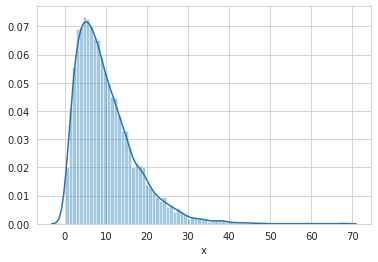

In [9]:
sns.distplot(data.x, bins=80)

In [10]:
gamma_fit_x = ot.GammaFactory().build(sample.getMarginal(0))

We then check that our fitted distribution correctly fits the observations by producing a sample from our fitted distribution and check whether it corresponds to our observations.

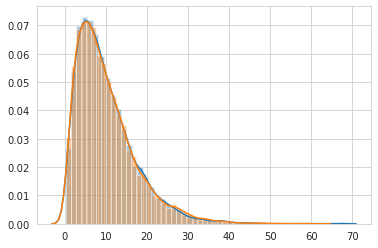

In [11]:
sns.distplot(np.array(sample.getMarginal(0)))
sns.distplot(np.array(gamma_fit_x.getSample(len(data.x))))

We now do the same for our y (coming from our initial beta distribution).

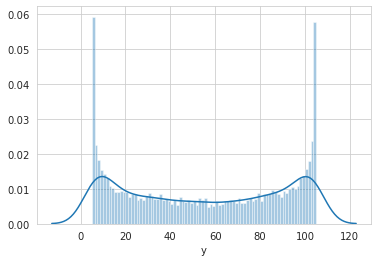

In [12]:
sns.distplot(data.y, bins=80)

In [13]:
beta_fit_y = ot.BetaFactory().build(sample.getMarginal(1))

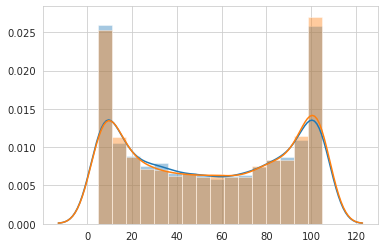

In [14]:
sns.distplot(np.array(sample.getMarginal(1)))
sns.distplot(np.array(beta_fit_y.getSample(len(data.y))))

We can also plot our bivariate data at this stage.

gamma_1 and beta_2 have a linear correlation of 71.23 %


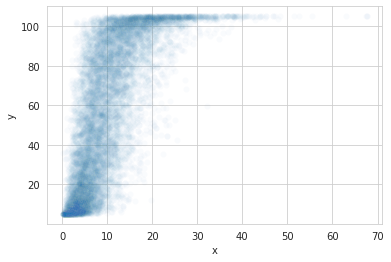

In [15]:
sns.scatterplot(data=data, x='x', y='y', alpha=0.025)
print(
    f'gamma_1 and beta_2 have a linear correlation of {round(stats.pearsonr(data.x, data.y)[0] * 100, 2)} %'
)

#### Get the rank data and plot the empirical copula

For each of x and y, we create an array made of the rank of each data points (if there is a strong correlation between the two variables, both variables should be ordered in a specific way : either big values from x are generally associated to big values of y, or big values of x are generally associated to small values of y).

We then standardized our data to obtain values ranging from 0 to 1.

Example: if our data is made of (3.8, 2.2, 2.3, 4.5) we should get (0.75, 0.25, 0.5, 1.0).

In [16]:
x_rank = list(np.array(pd.Series(data.x).rank(method='dense')) / len(data.x))
y_rank = list(np.array(pd.Series(data.y).rank(method='dense')) / len(data.y))

We can now plot our "ordered" data to obtain a representation of the dependency relation between gamma_1 and beta_2. 

This is actually what we call an "empirical copula".

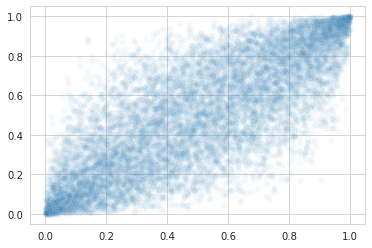

In [17]:
sns.scatterplot(x_rank, y_rank, alpha=0.05)

#### Fitting the empirical copula

We can now do the same as before when we fitted a distribution to our data. In real-life use case, we do not know that this is a Gaussian copula, and we should try different copulas to find which one best fits our empirical copula (as we do in real-life use cases when we want to fit a distribution to an histogram).

In [18]:
copula_fit = ot.NormalCopulaFactory().build(sample)

In [19]:
print(copula_fit.getParameter())

[0.803693]


We notice here that the parameter we obtained from our normal (i.e. Gaussian) copula is really close to the initial roh we set (at 80%), corresponding to the "Gaussian" correlation between our initial two variables.

#### Group the (fitted) copula and the (fitted) marginal distributions

We put in a single list our two fitted distributions.

In [20]:
marginals_fit = [gamma_fit_x, beta_fit_y]

And we combine them with our fitted copula to created a joint fitted distribution.

In [21]:
distribution_fit = ot.ComposedDistribution(marginals_fit, copula_fit)

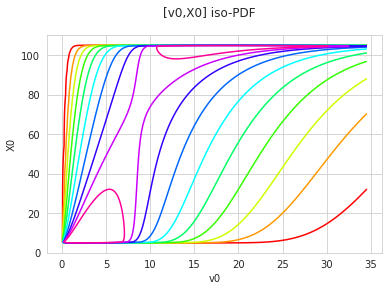

In [22]:
fig, ax = plt.subplots()
View(distribution_fit.drawPDF(200), figure=fig, axes=[ax], add_legend=False)
plt.show()

We can now create a sample from this fitted joint distribution and check that it fits our initial observations.

In [23]:
test = np.array(distribution_fit.getSample(10000)).transpose()

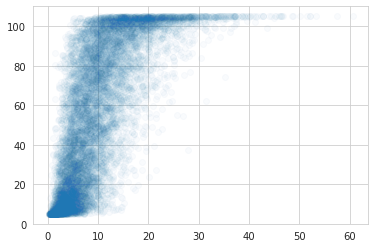

In [24]:
plt.scatter(test[0], test[1], alpha=0.025)

We can also get the joint cumulative distribution function (for any couple$(a,b)$ we can get $P(X \le a, Y \le b)$).

In [38]:
distribution_fit.computeCDF((85, 24))

0.2872112867663738